# 3D analysis open problem

In [50]:
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

from gammapy.catalog import SourceCatalogGammaCat
from gammapy.datasets import MapDataset, Datasets
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks, find_peaks_in_flux_map
from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Model,
    Models,
)

In [2]:
# we need to set the path of the IRF:
%env CALDB=../caldb/

env: CALDB=../caldb/


In [3]:
data_store = DataStore.from_dir("../output")

In [4]:
#source coordinates
l, b = 341.90669676 * u.deg, -3.62457011 * u.deg 
pointing = SkyCoord(l, b, frame="galactic")

In [8]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon=pointing.galactic.l.deg,
    lat=pointing.galactic.b.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [9]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations[0])

Observation

	obs id            : 5000002225 
 	tstart            : 61884.22
	tstop             : 61884.24
	duration          : 1575.00 s
	pointing (icrs)   : 255.2 deg, -43.8 deg

	deadtime fraction : 0.0%



Now, we generate the 'stacked' dataset:

In [10]:
energy_axis = MapAxis.from_energy_bounds(0.012, 100.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.galactic.l.deg , pointing.galactic.b.deg),
    binsz=0.01,
    width=(5, 5),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [11]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

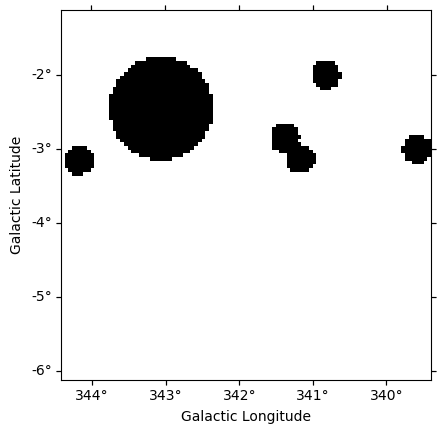

In [12]:
exclusion_src1 = CircleSkyRegion(
    center=SkyCoord(344.1646678, -3.16256952, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src2 = CircleSkyRegion(
    center=SkyCoord(343.05454002, -2.46546336, unit="deg", frame="galactic"),
    radius=0.7 * u.deg,
)
exclusion_src3 = CircleSkyRegion(
    center=SkyCoord(341.17287207, -3.14538304, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src4 = CircleSkyRegion(
    center=SkyCoord(341.38004212, -2.86952312, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src5 = CircleSkyRegion(
    center=SkyCoord(340.82287577, -2.01295808, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src6 = CircleSkyRegion(
    center=SkyCoord(339.58634079, -3.01718097, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)

exclusion_geom = WcsGeom.create(
    npix=(100, 100), binsz=0.05, skydir=pointing.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~exclusion_geom.region_mask([exclusion_src1, exclusion_src2, exclusion_src3,
                                   exclusion_src4, exclusion_src5, exclusion_src6])
exclusion_mask.plot()
plt.show()

In [13]:
offset_max = 6 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [14]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 37, Background norm obs 5000002225: 1.16
1 of 37, Background norm obs 5000002226: 1.19
2 of 37, Background norm obs 5000002250: 1.07
3 of 37, Background norm obs 5000002251: 1.08
4 of 37, Background norm obs 5000002280: 1.07
5 of 37, Background norm obs 5000002307: 1.02
6 of 37, Background norm obs 5000002308: 1.28
7 of 37, Background norm obs 5000002404: 1.07
8 of 37, Background norm obs 5000002405: 1.08
9 of 37, Background norm obs 5000002436: 1.00
10 of 37, Background norm obs 5000002437: 1.11
11 of 37, Background norm obs 5000002459: 1.02
12 of 37, Background norm obs 5000002461: 0.90
13 of 37, Background norm obs 5000002635: 1.13
14 of 37, Background norm obs 5000002636: 1.20
15 of 37, Background norm obs 5000002652: 1.09
16 of 37, Background norm obs 5000002653: 1.08
17 of 37, Background norm obs 5000002666: 1.02
18 of 37, Background norm obs 5000002667: 2.00
19 of 37, Background norm obs 5000002723: 1.02
20 of 37, Background norm obs 5000002831: 1.05
21 of 37, Background no

Let's inspect the field:

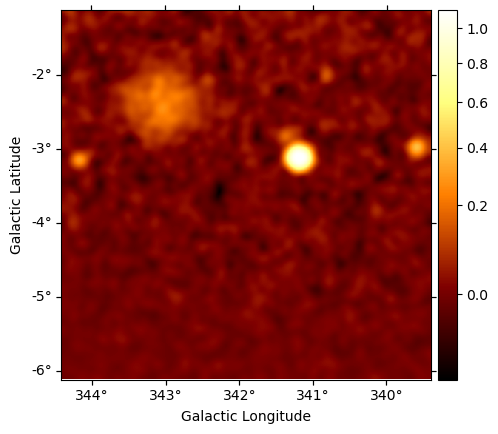

In [15]:
excess = stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

In [16]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-22 cm-2 s-1 keV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [17]:
estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    energy_edges=[0.03, 50] * u.TeV,
)
maps = estimator.run(stacked)

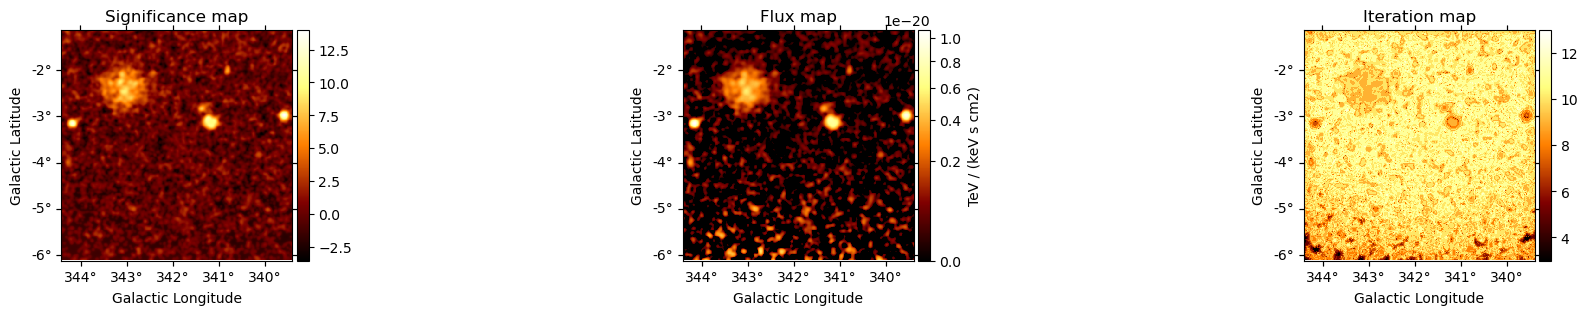

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(20, 3),
    subplot_kw={"projection": stacked.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")
plt.show()

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
14.028,481,313,254.71547,-47.45615
12.98,24,295,258.84397,-43.90530
10.921,316,304,256.29637,-46.20685
9.1767,136,364,257.14903,-44.40691
9.0533,128,385,256.98008,-44.21748
8.0791,159,381,256.76563,-44.48976
7.6023,303,327,256.14575,-45.96419
6.4101,358,409,254.72962,-45.89609


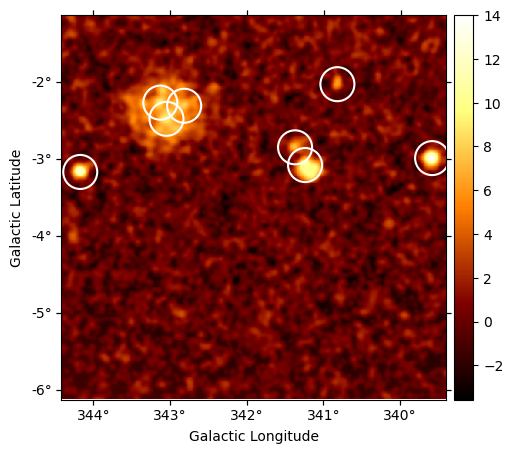

In [22]:
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.15 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

# sphinx_gallery_thumbnail_number = 3

In [25]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0
    
models_stacked = Models([bkg_model])

In [26]:
for i, src in enumerate(sources):
    print(f"- Analysis of the source {i+1}...")

    spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
            )
    
    spatial_model = GaussianSpatialModel(
    lon_0=src["ra"] * u.deg, lat_0=src["dec"] * u.deg, frame="icrs",
    sigma="0.1 deg"
            )

    model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name=f"src_{i}",
            )

    models_stacked.extend(Models([model]))
    
    stacked.models = models_stacked

    stacked.models[-1].parameters["lon_0"].frozen = True
    stacked.models[-1].parameters["lat_0"].frozen = True

    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[stacked])
    print(result)
    print(f"   * Analysis of the source {i+1}... complete!")

#    for n in stacked.models[-1].parameters.names:
#        stacked.models[-1].parameters[n].frozen = True


- Analysis of the source 1...
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 156
	total stat : 270879.23

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 1... complete!
- Analysis of the source 2...
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000237034 is smaller than machine limit 0.0161355 while 0.0002 was requested
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 311
	total stat : 270707.97

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 2... complete!
- Analysis of the source 3...


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/modeling/models/spatial.py:654: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0263514 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -3256.03
W MnPosDef non-positive diagonal element in covariance matrix[ 7 ] = -0.00214003
W MnPosDef non-positive diagonal element in covariance matrix[ 8 ] = -1.94416e-06
W MnPosDef Added to diagonal of Error matrix a value 3256.53
W VariableMetricBuilder gdel = -8.67631e+07


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/si

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.188454 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000301552 is smaller than machine limit 0.016085 while 0.0002 was requested
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1113
	total stat : 269861.55

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 3... complete!
- Analysis of the source 4...
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0104777 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -15.4514
W MnPosDef Added to diagonal of Error matrix a value 15.9514
W VariableMetricBuilder gdel = -787.332
W MnPosDef Matrix f

In [28]:
print(stacked.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.015   +/-    0.01             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: SkyModel

  Name                      : src_0
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.005   +/-    0.08             
    amplitude                     :   5.28e-13   +/- 7.0e-14 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    254.715       deg         
    lat_0                 (frozen):    -47.456       deg    

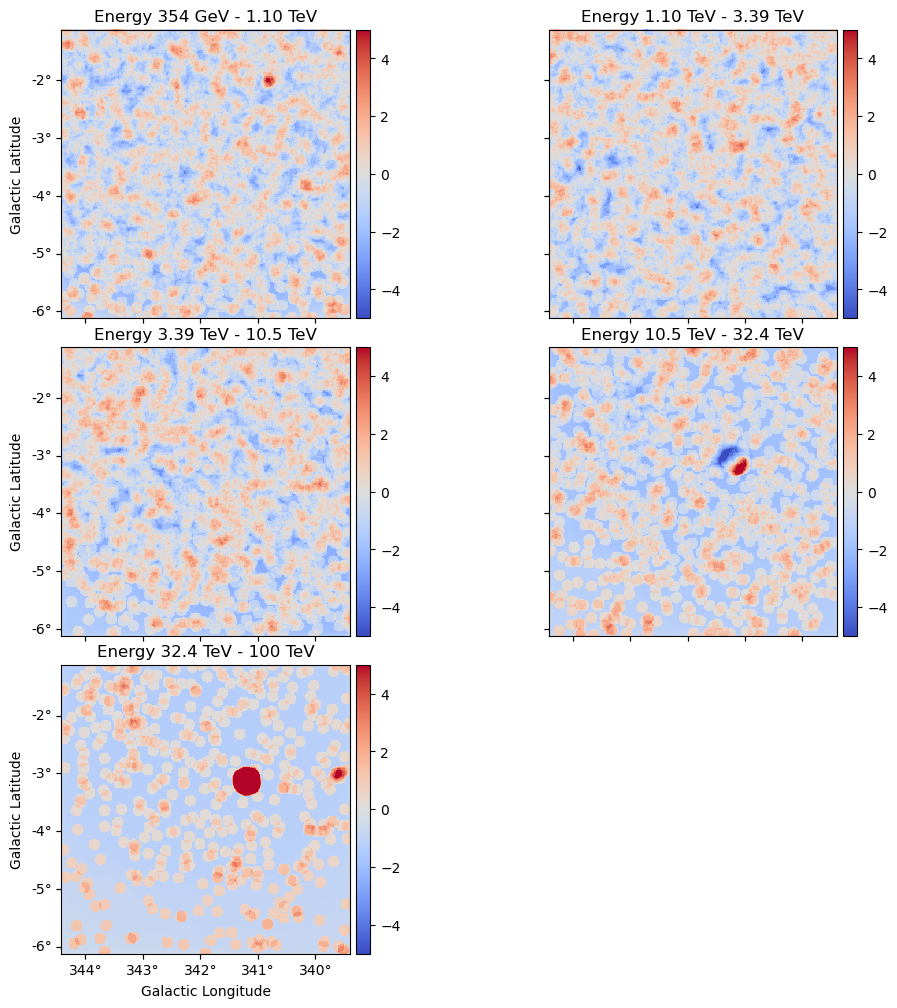

In [29]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.3, 1, 5, 10, 20, 100] * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 12), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

In [30]:
ra, dec, index, amplitude, sigma = [], [], [], [], []
for mod in stacked.models[1:]:
    ra.append(mod.spatial_model.lon_0.value) 
    dec.append(mod.spatial_model.lat_0.value) 
    index.append(mod.spectral_model.index.value) 
    amplitude.append(mod.spectral_model.amplitude.value) 
    sigma.append(mod.spatial_model.sigma.value) 

In [31]:
catalogue = Table()

catalogue["Src"] = np.arange(len(ra)) + 1
catalogue["Ra"] = ra * u.deg
catalogue["Dec"] = dec * u.deg
catalogue["Amplitude"] = amplitude  * u.cm**-2 * u.s**-1 * u.TeV**-1
#catalogue["Amplitude_err"]
catalogue[r"$\Gamma$"] = index
#catalogue["Index_err"]
catalogue[r"$\sigma$"] = sigma * u.deg
catalogue["Sqrt TS"] = sources["value"]
#catalogue["sigma_err"]

print(catalogue)

Src         Ra                 Dec         ...       $\Gamma$              $\sigma$       Sqrt TS
           deg                 deg         ...                               deg                 
--- ------------------ ------------------- ... -------------------- --------------------- -------
  1   254.715469322397  -47.45615139697405 ...   2.0053152974889197   0.04569088450714198  14.028
  2  258.8439684898101  -43.90530489696395 ...    3.314356185907066 0.0005252683727839122   12.98
  3  256.2963711327568  -46.20684552804714 ... -0.18389577909616195   0.10056409294866936  10.921
  4  257.1490256687629  -44.40690852492091 ...    2.025512303633353    0.2820667785318832  9.1767
  5 256.98007714301366  -44.21748153680484 ...   1.8538339542075963   0.30234829899268845  9.0533
  6 256.76562967473507 -44.489759694603784 ...   2.1496667521488875   0.26778879192237964  8.0791
  7  256.1457464123502  -45.96418601261675 ...   2.6668255871302837  0.031427930183234636  7.6023
  8 254.729622057903

In [51]:
catalog = SourceCatalogGammaCat()

i = 4
src_coord = SkyCoord(catalogue["Ra"][i], catalogue["Dec"][i], frame="icrs", unit="deg")
idx = np.argmin(src_coord.separation(catalog.positions).degree)
catalog[idx]